## Traininig the High Level Feature classifier with TensorFlow/Keras using data in TFRecord format

**Tensorflow/Keras and TFRecord, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Data is read using TensorFlow from files in TFRecord format.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Create the Keras model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [2]:
tf.version.VERSION

'2.12.0'

In [ ]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

In [ ]:
def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

In [5]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                750       
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Load data and train the Keras model

In [6]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

folder = PATH + "testUndersampled_HLF_features.tfrecord"

files_test_dataset = tf.data.Dataset.list_files(folder + "/part-r*", shuffle=False)

# training dataset 
folder = PATH + "trainUndersampled_HLF_features.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(folder + "/part-r*", seed=4242)

In [7]:
test_dataset=tf.data.TFRecordDataset(files_test_dataset)

train_dataset=tf.data.TFRecordDataset(files_train_dataset)

In [8]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [9]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          })
    return(deser_features['HLF_input'], deser_features['encoded_label'])

In [10]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
# Show and example of the parsed data
for record in parsed_test_dataset.take(1):
    print(record)

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([1.51507333e-02, 3.51102836e-03, 8.74629617e-01, 1.06784595e-04,
       1.33333340e-01, 0.00000000e+00, 7.00169418e-04, 2.50178307e-01,
       2.44209673e-02, 5.44097781e-01, 1.05042383e-01, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>)


2023-05-16 12:11:40.927328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


In [12]:
# Tunables
shuffle_size = 100000
batch_size = 128

train=parsed_train_dataset.shuffle(shuffle_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.cache()
train=train.batch(batch_size)

In [13]:
train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [14]:
test_batch_size = 10240

test=parsed_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.cache()
test=parsed_test_dataset.batch(test_batch_size)


In [15]:
# Train the Keras model
%time history = keras_model.fit(train, validation_data=test, epochs=5)


Epoch 1/5


2023-05-16 12:11:41.230437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-05-16 12:11:41.230948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-05-16 12:11:52.796082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 89082 of 100000
2023-05-16 12:11:54.005048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-05-16 12:12:15.790418: I tensorflow/compiler/xla/se

  26761/Unknown - 653s 23ms/step - loss: 0.2784 - accuracy: 0.8976

2023-05-16 12:22:37.560203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


26767/26767 [==============================] - 746s 26ms/step - loss: 0.2784 - accuracy: 0.8976 - val_loss: 0.2536 - val_accuracy: 0.9063
Epoch 2/5
26767/26767 [==============================] - 207s 8ms/step - loss: 0.2453 - accuracy: 0.9094 - val_loss: 0.2425 - val_accuracy: 0.9106
Epoch 3/5
26767/26767 [==============================] - 206s 8ms/step - loss: 0.2386 - accuracy: 0.9118 - val_loss: 0.2371 - val_accuracy: 0.9126
Epoch 4/5
26767/26767 [==============================] - 202s 8ms/step - loss: 0.2346 - accuracy: 0.9133 - val_loss: 0.2345 - val_accuracy: 0.9138
Epoch 5/5
26767/26767 [==============================] - 204s 8ms/step - loss: 0.2323 - accuracy: 0.9143 - val_loss: 0.2321 - val_accuracy: 0.9147
CPU times: user 19min 16s, sys: 29min 58s, total: 49min 15s
Wall time: 26min 9s


## Performance metrics

<IPython.core.display.Javascript object>


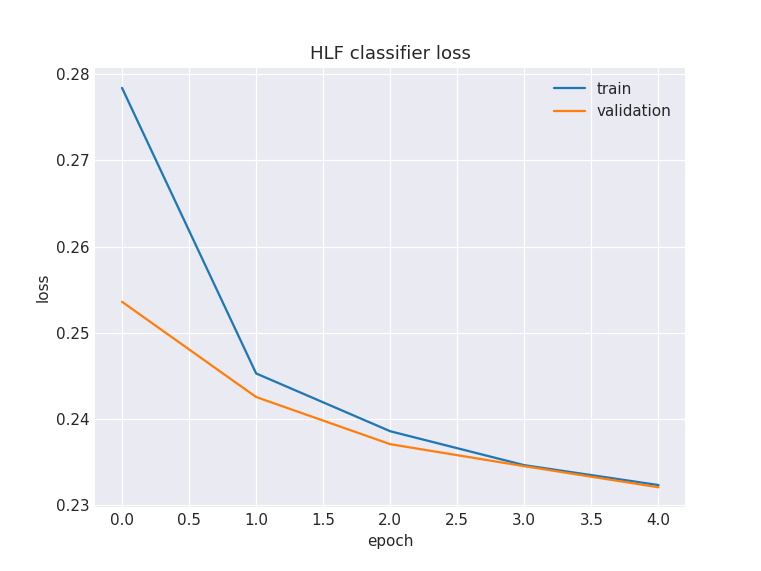

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


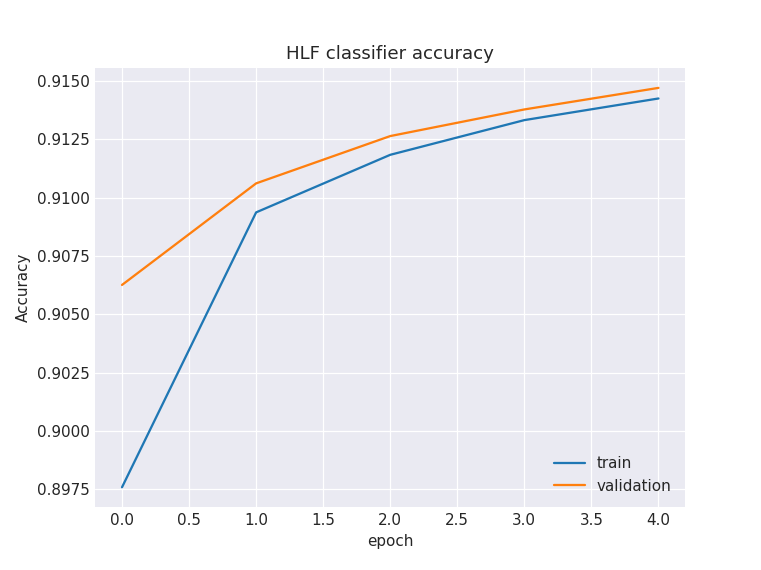

In [17]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [18]:
y_pred = history.model.predict(test)

84/84 [==============================] - 90s 1s/step


In [19]:
# extract the labels from parsed_test_dataset
%time y_true = np.stack([labels.numpy() for features,labels in parsed_test_dataset.__iter__()])

2023-05-16 13:22:11.034105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]


CPU times: user 4min 41s, sys: 2min 59s, total: 7min 40s
Wall time: 4min 23s


In [20]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9147


/tmp/ipykernel_408/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


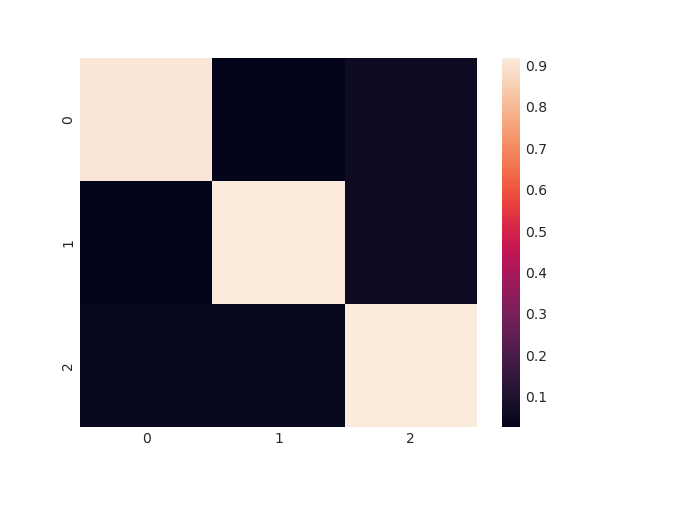

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [22]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [23]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9869287159715288, 1: 0.9850752385894902, 2: 0.9810330601430661}

<IPython.core.display.Javascript object>


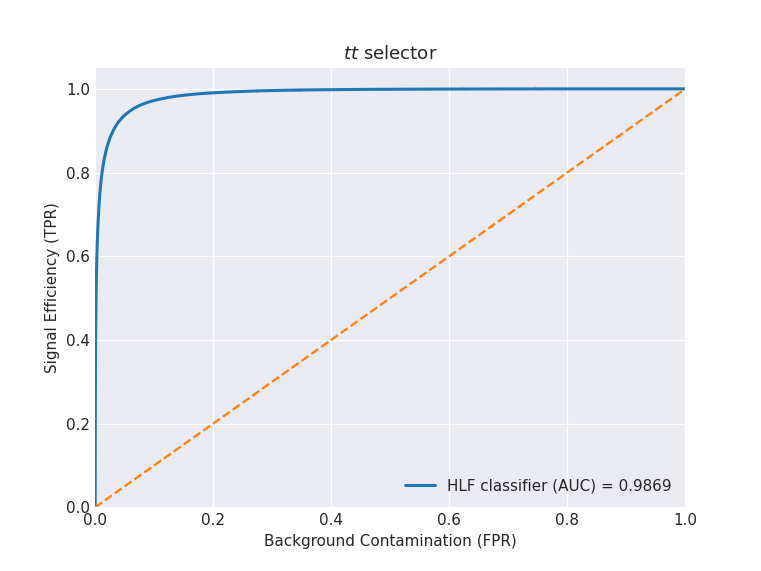

In [24]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()